In [1]:
%matplotlib notebook
from __future__ import division

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from matplotlib.pyplot import plot, ylabel, xlabel, yscale, xscale, legend, subplots, gca, gcf, subplots
from matplotlib.ticker import FormatStrFormatter
from theano import function
import numpy as np
import gzip
import cPickle
from scipy.optimize import minimize
from climin.util import optimizer
from itertools import repeat, cycle, islice, izip, imap, islice
import random
import time
inf = float("inf")

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
from breze.learn.data import one_hot
from breze.learn.base import cast_array_to_local_type
from schlichtanders.myfunctools import compose, meanmap, summap, compose_fmap, Average
from schlichtanders import myfunctools
from schlichtanders.mygenerators import eatN, chunk, chunk_list, every, takeN
from schlichtanders.myplot import add_val, add_point

In [4]:
from theano_models import (Merge, Flatten, Reparameterize, reduce_all_identities,
                           fix_params, inputting_references, outputting_references)
from theano_models.tools import (as_tensor_variable, total_size, clone, clone_all,PooledRandomStreams,
                                 get_profile, squareplus, squareplus_inv, softplus, softplus_inv)
from theano_models.visualization import d3viz
from IPython.display import IFrame
import theano_models.deterministic_models as dm
import theano_models.probabilistic_models as pm
import theano_models.extra_models as em
import theano_models.postmaps as post
from theano_models.composing import normalizing_flow, variational_bayes

In [5]:
import theano
import theano.tensor as T
from theano.printing import debugprint
from theano.tensor.shared_randomstreams import RandomStreams

In [6]:
from sqlalchemy import Column, Integer, Unicode, UnicodeText, String, PickleType, Float
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base

In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
inputting_references.update(['to_be_randomized'])
inputting_references, outputting_references

({'flat',
  'inputs',
  'n_data',
  'noise',
  'parameters',
  'parameters_positive',
  'parameters_psumto1',
  'to_be_randomized'},
 {'kl_prior', 'logP', 'loglikelihood', 'norm_det', 'outputs'})

# model

In [48]:
data_model = pm.Gauss(2, init_var=np.exp(-7))
data_model = Merge(data_model, parameters_positive=None)
data_model

Merge5 { 'inputs': [],
  'logP': <FunctionWrapper at 0x7f95c6d16de0 for function at 0x7f95c77f1398>,
  'noise': [GaussianNoise5.noise.0],
  'outputs': GaussianNoise5.outputs,
  'parameters': [mean5],
  'parameters_positive': []}

In [49]:
param_model_base = pm.Gauss(2)
param_model_base = Merge(param_model_base, parameters=None)
param_model_normflows = [dm.PlanarTransform()]

param_model = param_model_base
for transform in param_model_normflows:
    param_model = normalizing_flow(transform, param_model)  # returns Merge
param_model

normalized_flow3 { 'inputs': [],
  'logP': <FunctionWrapper at 0x7f95c6d16e50 for function at 0x7f95c77adb90>,
  'noise': [GaussianNoise6.noise.0],
  'norm_det': PlanarTransform3.norm_det,
  'outputs': PlanarTransform3.outputs,
  'parameters': [b3, w, _u3],
  'parameters_positive': [var6]}

In [50]:
prior = pm.Gauss(2, init_var=np.exp(-3))
# label hyper parameters accordingly
prior = Merge(prior, parameters=None)
prior

Merge7 { 'inputs': [],
  'logP': <FunctionWrapper at 0x7f95c6d16ec0 for function at 0x7f95fb02a488>,
  'noise': [GaussianNoise7.noise.0],
  'outputs': GaussianNoise7.outputs,
  'parameters': [],
  'parameters_positive': [var7]}

In [51]:
model = variational_bayes(data_model, 'parameters', param_model, priors=prior)
model

variational_lower_bound2 { 'inputs': [],
  'kl_prior': kl_prior,
  'logP': <FunctionWrapper at 0x7f96041f3130 for function at 0x7f95fb02ac08>,
  'loglikelihood': <FunctionWrapper at 0x7f95c6d16de0 for function at 0x7f95c77f1398>,
  'n_data': n_data,
  'noise': [ GaussianNoise5.noise.0,
             GaussianNoise6.noise.0,
             GaussianNoise7.noise.0],
  'norm_det': PlanarTransform3.norm_det,
  'outputs': GaussianNoise5.outputs,
  'parameters': [b3, w, _u3],
  'parameters_positive': [var6, var7]}

In [52]:
# model = Merge(model, Reparameterize(model['parameters_positive'], squareplus, squareplus_inv))
# UncertainWeights uses softplus parameterization
model = Merge(model, Reparameterize(model['parameters_positive'], softplus, softplus_inv))
model = Merge(model, Flatten(model['parameters']))
model

Merge9 { 'flat': "b3:w:_u3:var6_softplus:var7_softplus",
  'inputs': [],
  'kl_prior': kl_prior,
  'logP': <FunctionWrapper at 0x7f96041f3130 for function at 0x7f95fb02ac08>,
  'loglikelihood': <FunctionWrapper at 0x7f95c6d16de0 for function at 0x7f95c77f1398>,
  'n_data': n_data,
  'noise': [ GaussianNoise5.noise.0,
             GaussianNoise6.noise.0,
             GaussianNoise7.noise.0],
  'norm_det': PlanarTransform3.norm_det,
  'outputs': GaussianNoise5.outputs,
  'parameters': [],
  'parameters_positive': []}

# target

In [53]:
param_target_base = pm.Gauss(2, init_mean=[0,0], init_var=2)
param_target_normflows = [dm.PlanarTransform(init__u=[3,6], init_w=[1,3], init_b=-1) for _ in range(1)]

param_target = param_target_base
for transform in param_target_normflows:
    param_target = normalizing_flow(transform, param_target)  # returns Merge
param_target

normalized_flow4 { 'inputs': [],
  'logP': <FunctionWrapper at 0x7f9604602280 for function at 0x7f95fb00fe60>,
  'noise': [GaussianNoise8.noise.0],
  'norm_det': PlanarTransform4.norm_det,
  'outputs': PlanarTransform4.outputs,
  'parameters': [b4, w, _u4, mean8],
  'parameters_positive': [var8]}

In [54]:
target = param_target
t_sampler = target.function()
n_samples = 10000
training = np.array([t_sampler() for _ in xrange(n_samples)])
validation = np.array([t_sampler() for _ in xrange(1000)])

In [55]:
d3viz(param_target, "tmp/param_target.html")
IFrame("tmp/param_target.html", width=600, height=400)

# optimizer

In [56]:
reduce_all_identities()

In [57]:
batch_size = 20
n_batches = len(targets) // batch_size  # after this many steps we went through the whole data set once

climin_args = izip(imap(lambda x:(x,), chunk(batch_size, cycle(training))), repeat({}))

def weights_regularizer_1epoch():
    for i in range(1, n_batches+1):
        yield 2**(n_batches - i) / (2**n_batches - 1)
        
assert len(list(weights_regularizer_1epoch())) == n_batches

In [69]:
mapreduce = summap
average_n = 1
if average_n > 1:
    mapreduce = compose_fmap(Average(average_n), mapreduce)

postmap = compose(post.flat_numericalize_postmap, post.variational_postmap) 
postmap_kwargs = {
    'mapreduce': mapreduce,  # TODO add more functionality for composed fmaps, with args
    'annealing_combiner': post.AnnealingCombiner(
        weights_regularizer=cycle(weights_regularizer_1epoch())
    ),
    'adapt_init_params': lambda ps: ps + np.random.normal(size=ps.size, scale=0.1),
#     'profile': True,
    'mode': 'FAST_RUN'
}
optimizer_kwargs = postmap(model, **postmap_kwargs)
climin_kwargs = post.climin_postmap(optimizer_kwargs)
climin_kwargs

{'f': <function theano_models.postmaps.annealed>,
 'fprime': <function theano_models.postmaps.annealed>,
 'wrt': array([-0.19765182,  1.01566856,  1.06261776,  0.92215166,  1.03871334,
         0.55476415, -3.03826429])}

In [70]:
opt = optimizer(
#     identifier='adam',
    identifier="rmsprop",
    step_rate=1e-2,
    momentum=0.9,
    args=climin_args,
    **climin_kwargs
)

## Fit Visualization

In [71]:
scatter_kwargs = dict(edgecolors="face", alpha=0.01, s=5000)
outer = dict(i=0)
example_samples = 1000
def plot_fit(fig, ax, givens={}, time_delay=0.1):
    outer['i'] += 1
    ax.clear()
    
    # targets
    ax.plot(targets[:example_samples,0], targets[:example_samples,1], 'k.')
#     ax.scatter(targets[:,0], targets[:,1], c='k', **scatter_kwargs)

    # model
    m_sampler = model.function(givens=givens, mode="FAST_COMPILE")
    m_samples = np.array([m_sampler() for _ in xrange(example_samples)])
    ax.scatter(m_samples[:,0], m_samples[:,1], c='r',**scatter_kwargs)

    fig.canvas.draw()
    if time_delay is not None:
        time.sleep(time_delay)

<IPython.core.display.Javascript object>


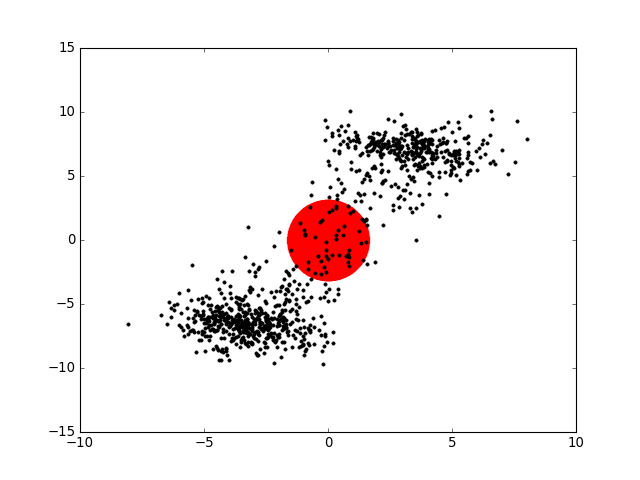

In [72]:
fig, ax = subplots()
plot_fit(fig, ax)

In [73]:
best_parameters = None
best_val_loss = inf
last_improvement_epoch = 1
for info in every(n_batches, opt):
    current_epoch = info['n_iter']//n_batches
    if current_epoch - last_improvement_epoch > 50:
        break
    # collect and visualize validation loss for choosing the best model
    val_loss = optimizer_kwargs['num_loss'](opt.wrt, training, no_annealing=True)
    if val_loss < best_val_loss:
        last_improvement_epoch = current_epoch
        best_parameters = opt.wrt
        best_val_loss = val_loss
    
    print zip(model['flat'].name.split(':'), climin_kwargs['fprime'](opt.wrt, training[:100], no_annealing=True))
    plot_fit(fig, ax, givens={model['flat']: opt.wrt}, time_delay=None)
    print best_val_loss,

[('"b3', -0.0017263118269387526), ('w', -0.0037338881882481175), ('_u3', -0.0042593724830060301), ('var6_softplus', -0.004060487943757486), ('var7_softplus"', -0.0042312657980403939)]
27933.1350036 [('"b3', 0.0048845372699153691), ('w', -0.0027915312209960065), ('_u3', -0.0030154763479768943), ('var6_softplus', -0.0029488620131317665), ('var7_softplus"', -0.0030200765501824079)]
27933.1350036 [('"b3', -0.003820178965115655), ('w', -0.0021103020493142416), ('_u3', -0.0022211325586793205), ('var6_softplus', -0.0021986602800748646), ('var7_softplus"', -0.0022323828454324239)]
27933.1350036 [('"b3', 0.0052790652917316617), ('w', -0.0016940124522588419), ('_u3', -0.0016933098226224056), ('var6_softplus', -0.0017305974182826808), ('var7_softplus"', -0.0017511863194829033)]
27933.1350036 [('"b3', -0.0046873402019894572), ('w', -0.0013943676239303066), ('_u3', -0.0014406474533952224), ('var6_softplus', -0.0014318841514350416), ('var7_softplus"', -0.0014422724282094363)]
27933.1350036 [('"b3', 

KeyboardInterrupt: 

In [ ]:
%debug

In [ ]:
optimizer_kwargs['flat']

In [ ]:
%timeit optimizer_kwargs['num_jacobian'](best_parameters, targets[:100])

In [ ]:
stats = np.array([optimizer_kwargs['num_jacobian'](best_parameters, targets[:100]) for _ in range(1000)])

In [ ]:
stats[:100]

In [ ]:
plot(stats.T)
pass

In [ ]:
stats.mean(0)

In [ ]:
stats.var(0)

In [ ]:
opt.n_iter

In [ ]:
model.u.eval({model['flat']: best_parameters})

In [47]:
theano.function([model['flat']], 
                [model.b, target.b,
                 model.w, target.w,
                 model._u, target._u, 
                 param_model_base.mean, 
                 param_target_base.mean, 
                 param_model_base.var, param_target_base.var,
                 data_model.var],
                mode="FAST_COMPILE")(best_parameters)

[array(0.06547236359945446),
 array(-1.0),
 array([ 1.37626268,  1.41357919]),
 array([ 1.,  3.]),
 array([ 1.39112563,  1.28271282]),
 array([ 3.,  6.]),
 array([ 0.,  0.]),
 array([ 0.,  0.]),
 array(0.010521653958982724),
 array(2.0),
 array(16.750065427548464)]

In [ ]:
best_val_loss

Using the default scipy optimizer, one can see very good, that the problem is ill-defined in that the maximum likelihood solution is a ill-formed solution.